In [11]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
warnings.filterwarnings("ignore")


##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf


In [12]:
##  SETUP DIRECTORIES

dir_cur = pathlib.Path(os.getcwd())
dir_data = dir_cur.joinpath("data")
dir_transformations = dir_cur.joinpath("transformations")


##  SETUP FILES

fp_data_base = dir_data.joinpath("sisepuede_inputs_iran.csv")


##  SETUP SOME SISEPUEDE STUFF

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

In [13]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

###   Review fields that are different

In [14]:
[
    x for x in df_inputs_example.columns if x not in df_inputs_raw.columns
]

['strategy_id']

In [15]:
##  SOME MANUAL FIXES FOR THE MOMENT

df_inputs_example["exports_enfu_pj_fuel_ammonia"] = 0


###   Build the file here

- Drop unecessary fields
- Use systematic keys/index fields
- add region name

In [16]:
fields_drop_example = [
    x for x in [regions.key, matt.dim_strategy_id]
    if x in df_inputs_example
]

fields_drop_raw = [
    x for x in ["iso_code3", "Year"]
    if x in df_inputs_example
]

df_inputs = sf.match_df_to_target_df(
    df_inputs_example
    .drop(
        columns = fields_drop_example,
    ),
    df_inputs_raw
    .drop(
        columns = fields_drop_raw,
    ),
    [time_periods.field_time_period],
    overwrite_only = False,
)

df_inputs[regions.key] = "iran"

#  Let's try building transformations using this


In [17]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs,
)


##  Instantiate some transformations CAREFUL NOT TO OVERWRITE EXISTING TRANSFORMATIONS!!

In [18]:
# set an ouput path and instantiate 
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--
- go to `dir_transformers` and edit config files and `strategy_definitions.csv`
- then, go to next cell

In [19]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table




In [20]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")



Strategies defined at /home/fabian_fuentes/repos/sisepuede_region_nbs/iran/transformations initialized in 3.0 seconds


In [21]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:CONSTRAINED,Constrained Climate Action,NaN,TX:AGRC:DEC_CH4_RICE_LOW|TX:AGRC:DEC_LOSSES_SU...,0
70,6004,PFLO:TECHNOLOGICAL_ADOPTION,Technology Adoption Scenario,NaN,TX:AGRC:DEC_CH4_RICE_LOW|TX:AGRC:DEC_LOSSES_SU...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [23]:
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups, 
    include_simplex_group_as_trajgroup = True,
    strategies = [0, 6003, 6004, 6005],
)



0

In [ ]:
#s0 = strategies.get_strategy(0)
#s0()["nemomod_entc_frac_min_share_production_pp_biogas"]

# Finally, load SISEPUEDE so that we can run it

In [24]:
import sisepuede as si

ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    regions = ["iran"],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2024-11-07 10:29:33,366 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-07 10:29:33,368 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-07 10:29:33,368 - INFO - 	Setting export engine to 'csv'.
2024-11-07 10:29:33,369 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-11-07 10:29:33,369 - INFO - Successfully instantiated table ANALYSIS_METADATA
2024-11-07 10:29:33,370 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2024-11-07 10:29:33,370 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2024-11-07 10:29:33,371 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2024-11-07 10:29:33,371 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2024-11-07 10:29:33,371 - WARNING - No index fi

[juliapkg] Found dependencies: /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/julia/pyjuliapkg/juliapkg.json
[juliapkg] Found dependencies: /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/juliapkg/juliapkg.json
[juliapkg] Locating Julia ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.11.1 to /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/julia/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from 

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Hwloc_jll ─ v2.11.2+1
   Installed HiGHS ───── v1.12.0
    Updating `~/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/julia/Project.toml`
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.1.0
  [a93c6f00] + DataFrames v1.7.0
  [60bf3e95] + GLPK v1.2.1
  [87dc4568] + HiGHS v1.12.0
  [b6b21f68] + Ipopt v1.6.7
  [4076af6c] + JuMP v1.23.3
  [a3c327a0] + NemoMod v2.0.0 `https://github.com/sei-international/NemoMod.jl.git#61e63e0`
⌅ [6099a3de] + PythonCall v0.9.22
  [0aa819cd] + SQLite v1.6.1
    Updating `~/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/julia/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.5.0
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.1.0
  [523fee87] + CodecBzip2 v0.8.4
  [944b1d66] + CodecZlib v0.7.6
  [bbf7d656] + CommonSubexpressions v0.3.1
  [34da2185] + Compat v4.16.0
  [992eb4ea] + CondaPkg v0.2.23
  [88353bc9] + ConfParser v0.1.2
  [a8c

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1844.0 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2024-11-07 10:31:08,073 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2024-11-07 10:31:08,102 - INFO - Successfully initialized SISEPUEDEModels.
2024-11-07 10:31:08,111 - INFO - Table ANALYSIS_METADATA successfully written to /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/

In [25]:
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: [0, 6003, 6004, 6005],
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
)

2024-11-07 10:31:08,277 - INFO - 
***	STARTING REGION iran	***

2024-11-07 10:31:10,929 - INFO - Trying run primary_id = 0 in region iran
2024-11-07 10:31:10,929 - INFO - Running AFOLU model
2024-11-07 10:31:11,059 - INFO - AFOLU model run successfully completed
2024-11-07 10:31:11,060 - INFO - Running CircularEconomy model
2024-11-07 10:31:11,099 - INFO - CircularEconomy model run successfully completed
2024-11-07 10:31:11,099 - INFO - Running IPPU model
2024-11-07 10:31:11,160 - INFO - IPPU model run successfully completed
2024-11-07 10:31:11,161 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-07 10:31:11,175 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-11-07 10:31:11,249 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-11-07 10:31:11,250 - INFO - Running Energy model (Electricity and Fuel Production: trying to ca

2024-07-Nov 10:31:11.655 Opened SQLite database at /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-07-Nov 10:31:11.897 Added NEMO structure to SQLite database at /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-07-Nov 10:31:24.384 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-07 10:32:22,026 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-07 10:32:22,038 - INFO - EnergyProduction model run successfully completed
2024-11-07 10:32:22,038 - INFO - Running Energy (Fugitive Emissions)


2024-07-Nov 10:32:21.850 Finished modeling scenario.


2024-11-07 10:32:22,079 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-07 10:32:22,079 - INFO - Appending Socioeconomic outputs
2024-11-07 10:32:22,088 - INFO - Socioeconomic outputs successfully appended.
2024-11-07 10:32:22,092 - INFO - Model run for primary_id = 0 successfully completed in 71.16 seconds (n_tries = 1).
2024-11-07 10:32:22,114 - INFO - Trying run primary_id = 69069 in region iran
2024-11-07 10:32:22,115 - INFO - Running AFOLU model
2024-11-07 10:32:22,267 - INFO - AFOLU model run successfully completed
2024-11-07 10:32:22,267 - INFO - Running CircularEconomy model
2024-11-07 10:32:22,315 - INFO - CircularEconomy model run successfully completed
2024-11-07 10:32:22,316 - INFO - Running IPPU model
2024-11-07 10:32:22,390 - INFO - IPPU model run successfully completed
2024-11-07 10:32:22,391 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-07 10:32:22,407 - DEBUG - Missing elasticity information found 

2024-07-Nov 10:32:23.554 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-07 10:33:27,173 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-07 10:33:27,184 - INFO - EnergyProduction model run successfully completed
2024-11-07 10:33:27,185 - INFO - Running Energy (Fugitive Emissions)


2024-07-Nov 10:33:27.016 Finished modeling scenario.


2024-11-07 10:33:27,223 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-07 10:33:27,224 - INFO - Appending Socioeconomic outputs
2024-11-07 10:33:27,231 - INFO - Socioeconomic outputs successfully appended.
2024-11-07 10:33:27,234 - INFO - Model run for primary_id = 69069 successfully completed in 65.12 seconds (n_tries = 1).
2024-11-07 10:33:27,240 - INFO - Trying run primary_id = 70070 in region iran
2024-11-07 10:33:27,240 - INFO - Running AFOLU model
2024-11-07 10:33:27,401 - INFO - AFOLU model run successfully completed
2024-11-07 10:33:27,401 - INFO - Running CircularEconomy model
2024-11-07 10:33:27,444 - INFO - CircularEconomy model run successfully completed
2024-11-07 10:33:27,445 - INFO - Running IPPU model
2024-11-07 10:33:27,510 - INFO - IPPU model run successfully completed
2024-11-07 10:33:27,510 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-07 10:33:27,525 - DEBUG - Missing elasticity information fo

2024-07-Nov 10:33:28.723 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-07 10:34:27,960 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-07 10:34:27,970 - INFO - EnergyProduction model run successfully completed
2024-11-07 10:34:27,970 - INFO - Running Energy (Fugitive Emissions)
2024-11-07 10:34:28,002 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-07 10:34:28,003 - INFO - Appending Socioeconomic outputs
2024-11-07 10:34:28,009 - INFO - Socioeconomic outputs successfully appended.
2024-11-07 10:34:28,012 - INFO - Model run for primary_id = 70070 successfully completed in 60.77 seconds (n_tries = 1).
2024-11-07 10:34:28,016 - INFO - Trying run primary_id = 71071 in region iran
2024-11-07 10:34:28,017 - INFO - Running AFOLU model


2024-07-Nov 10:34:27.814 Finished modeling scenario.


2024-11-07 10:34:28,151 - INFO - AFOLU model run successfully completed
2024-11-07 10:34:28,151 - INFO - Running CircularEconomy model
2024-11-07 10:34:28,192 - INFO - CircularEconomy model run successfully completed
2024-11-07 10:34:28,193 - INFO - Running IPPU model
2024-11-07 10:34:28,255 - INFO - IPPU model run successfully completed
2024-11-07 10:34:28,256 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-07 10:34:28,269 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-11-07 10:34:28,344 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-11-07 10:34:28,344 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2024-07-Nov 10:34:29.709 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-07 10:35:21,794 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-07 10:35:21,806 - INFO - EnergyProduction model run successfully completed
2024-11-07 10:35:21,807 - INFO - Running Energy (Fugitive Emissions)


2024-07-Nov 10:35:21.618 Finished modeling scenario.


2024-11-07 10:35:21,846 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-07 10:35:21,846 - INFO - Appending Socioeconomic outputs
2024-11-07 10:35:21,853 - INFO - Socioeconomic outputs successfully appended.
2024-11-07 10:35:21,856 - INFO - Model run for primary_id = 71071 successfully completed in 53.84 seconds (n_tries = 1).
2024-11-07 10:35:21,858 - INFO - 
***	 REGION iran COMPLETE	***

2024-11-07 10:35:21,957 - INFO - Table MODEL_OUTPUT successfully written to /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-07T10;29;32.900079/sisepuede_run_2024-11-07T10;29;32.900079_output_database/MODEL_OUTPUT.csv.
2024-11-07 10:35:21,960 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-07T10;29;32.900079/sisepuede_run_2024-11-07T10;29;32.900079_output_database/ATTRIBUTE_PRIMARY.csv.
2024-11-07 10:

{'iran': [0, 69069, 70070, 71071]}

In [ ]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [26]:
df_output = ssp.read_output(None)

In [27]:
df_output[ssp.key_primary].unique()

array([    0, 69069, 70070, 71071])

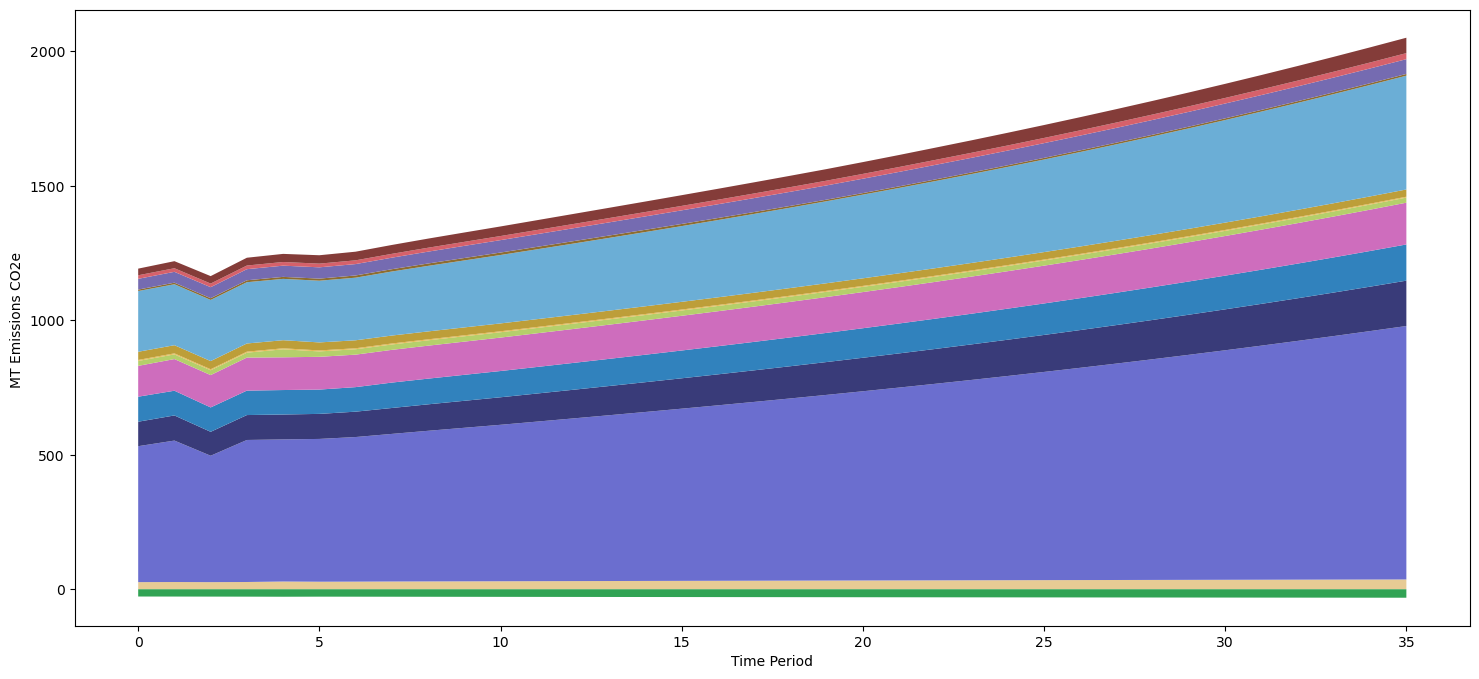

In [29]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_output[
    df_output[ssp.key_primary].isin([0])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)



# Export Wide File

In [31]:
df_out = ssp.read_output(None)
#df_in = ssp.read_input(None)

all_primaries = sorted(list(df_out[ssp.key_primary].unique()))
df_in = []
 
for region in ssp.regions:
    for primary in all_primaries: 
        df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
        df_in.append(df_in_filt.get(region))

df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)

df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)





# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    ssp.database.db.read_table(tab).to_csv(
        os.path.join(dir_pkg, f"{tab}.csv"),
        index = None,
        encoding = "UTF-8"
    )


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [32]:
ssp.file_struct.dir_out

'/home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/out'